# Инициализация для BigCLAM

In [1]:
import numpy as np
import scipy as sp
import scipy.spatial as spatial
import matplotlib.pyplot as plt
import networkx as nx
import cPickle
from Extends import toBigClamFormat, fromBigClamFormat
import subprocess
import os
from big_clam import *
from big_clam_gamma import BigClamGamma

# для отрисовки графов
from plotly import tools
import plotly.plotly as py
from plotly.graph_objs import *
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
init_notebook_mode()

from Experiments import *

%matplotlib inline 

Текущая инициализация выбирается с помощью метода, который называется locally minimal neighborhoods. Выбирается локальный минимум функционала под названием Conductance (проводимость) по всем эгографам. 

Conductance обозначается как $\phi$ и вычисляется для подграфа $S \in G$ как 

$$
\phi(S) = \dfrac{\mathrm{cut}(S)}{\min(\mathrm{vol}(S), \mathrm{vol}( \bar S))}
$$

миниум берется, т.к. Величина рассматривается для "меньшей" выделенной части графа. Здесь

$$\mathrm{cut}(S) = \mathrm{cut}(S, \bar S)=\sum_{\substack{(v,u)\in E\\ v \in S\\ u \in \bar S}} a_{vu},$$

$$\mathrm{vol}(S) =\sum_{(v,u)\in S} a_{vu}.$$

Возьмем стандартный пример для экспериментов и посмотрим, как на нем ведет себя эта величина

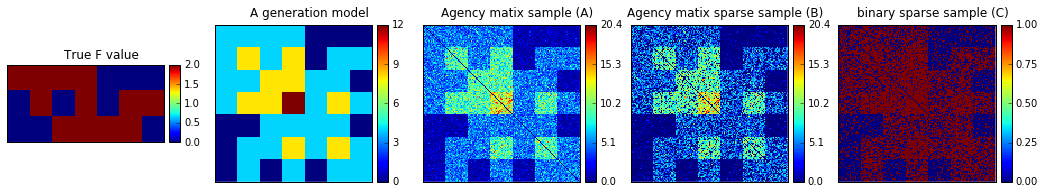

In [4]:
F_true = Fs3[0]
A = gamma_model_test_data(F_true)
power = 0.2
P = 1 - np.exp(- power * A)
mask = P <= np.random.rand(*A.shape)

B = A.copy()
B[mask] = 0
C = B.copy()
C[B != 0] = 1

draw_test_sample(F_true, A, B, C)

[12, 9, 84, 138, 122, 97, 91, 121]


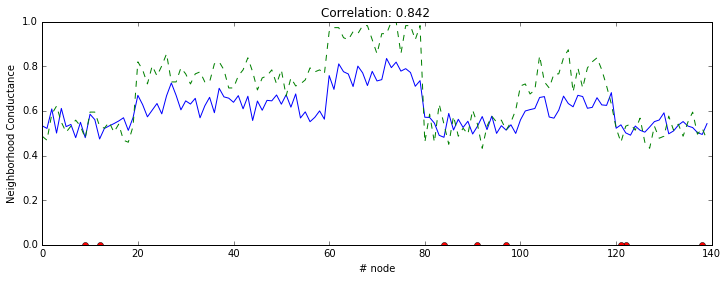

In [5]:
plt.figure(figsize=(12,4))
cond = GetNeighborhoodConductance(C)
degreeNorm = np.sum(C, axis=0) / np.max(np.sum(C, axis=0))
localmax = conductanceLocalMin(C)
print localmax
plt.plot(cond, 'b')
plt.plot(degreeNorm, 'g--')
plt.plot(localmax, [0]*len(localmax), 'r-o')
plt.xlabel('# node')
plt.ylabel('Neighborhood Conductance')
plt.title('Correlation: {:.3f} '.format(np.corrcoef(cond, degreeNorm)[1][0]))

Видно, что Conductance (синий график) очень хорошо улавливает струкруту матрицы, из которой генерируется граф (зеленый график показывает отнормированную сумму весов каждой из вершин матрицы А).

Посмотрим на эту величину на графе

In [6]:
def draw_graph(C, pos=None, color=None, highlight=None):

    G = nx.Graph(C)
    if pos is None:
        pos=nx.layout.spectral_layout(G)
        center = sum(pos[key] for key in pos) / len(pos)
        pos = {key:np.sign(pos[key]-center)*(2*(np.abs(pos[key]-center)))**0.6+center for key in pos}

    if color is None:
        color = GetNeighborhoodConductance(C)

    nx.set_node_attributes(G, 'pos', pos)
    nx.set_node_attributes(G, 'cond', color)

    edge_trace = Scatter(
        x=[], y=[],
        line=Line(width=0.15,color='rgba(100, 100, 100, 0.5)'),
        hoverinfo='none', mode='lines')

    for edge in G.edges():
        x0, y0 = G.node[edge[0]]['pos']
        x1, y1 = G.node[edge[1]]['pos']
        edge_trace['x'] += [x0, x1, None]
        edge_trace['y'] += [y0, y1, None]

    node_trace = Scatter(
        x=[], y=[], text=[],
        mode='markers',
        hoverinfo='text',
        marker=Marker(
            showscale=True,
            colorscale='YIGnBu',
            reversescale=True,
            color=[],
            size=10,
            colorbar=dict(
                thickness=15,
                title='Neighborhood Conductance',
                xanchor='left',
                titleside='right'
            ),
            line=dict(width=2, color=[])))

    for node in G.nodes():
        x, y = G.node[node]['pos']
        node_trace['x'].append(x)
        node_trace['y'].append(y)
        node_trace['marker']['line']['color'].append( '#911' if node in highlight else '#444')
        node_trace['marker']['color'].append(cond[node])
        node_info = '{}: {:.3f}'.format(node, cond[node]) + (' {}'.format(highlight.index(node)) if node in highlight else '' )
        node_trace['text'].append(node_info)

    fig = Figure(data=Data([edge_trace, node_trace]),
             layout=Layout(
                title='Sample Network graph',
                titlefont=dict(size=16),
                showlegend=False,
                width=800,
                height=650,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=XAxis(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=YAxis(showgrid=False, zeroline=False, showticklabels=False)))
    
    return fig

In [7]:
fig = draw_graph(C, highlight=localmax)
py.iplot(fig, filename='networkx', show_link=False)

High five! You successfuly sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~zurk/0 or inside your plot.ly account where it is named 'networkx'


# Разреженная инициализация

Посмотрим на количество общих вершин в эгографах вершин, где достигается локальный минимум проводимости.

**BTW**: позиции вершин расчитаны с помощью спектрального метода и он очень здорово располагает и отрисовывает такой модельный пример

In [8]:
Z = C[localmax].dot(C[localmax].T)/np.sum(C[localmax], axis=1)
np.fill_diagonal(Z, 0)
                    
data = [Heatmap(z=Z)]
fig = Figure(data=data, layout=Layout( width=400, height=400,  title=' Nodes interseption fraction'))
py.iplot(fig, filename='Egograph interception', show_link=False)

Видим местами значительные пересечения. Например, берем первый и второй по проводимости эгограф, получаем долю пересеечния в 60%. Это очень много. По первому графику видно, что локальные минимумы есть в каждой из стуктурных частей графа. Попробуем использовать эту матрицу, как матрицу штрафов для выбора сообществ, что и реализованно в функции *getSeedCenters*

In [9]:
A, B = getSeedCenters(C), conductanceLocalMin(C)
print A, B

[12, 121, 97, 122, 9, 91, 138, 84] [12, 9, 84, 138, 122, 97, 91, 121]


In [10]:
fig = draw_graph(C, highlight=A[:3])
fig['layout'].update(title='3 first Smart Seed Centers')
py.iplot(fig, filename='Network', show_link=False)

Итак, результат достигнут. Начальные точки лежат в разрозненных частях графа. До этого две точки: 12 и 9 лежали в одной части. Такой подход явно поможет избежать подобных ситуаций.

# Тест на реальных данных

В ходе тестовых испытаний, было замечено, что преимущественно нулевые значения матрицы $F$ так и остаются нулями, что может негативно сказываться на качестве полученного решения (привет, bigCLAM!). необходимо заполнять эти нули хотя бы шумом. Тем самым были добавлены новые способы инициализации: *cond_randz* и *cond_new_randz*, где вместо нулевых значений берется равномерный шум от нуля до 0.01(или до параметра *rand_init_coef*, если он установлен)

**Описание всех методов инициализации:**
* cond — стандартный метод (берем локальные максимумы)
* cond_new — Новый метод (см выше), штрафуем за пересечение с уже выбранными вершинами
* cond_randz — заменяем нули из метода *cond* на значения от 0 до 0.01(или до параметра *rand_init_coef*, если он установлен)
* cond_new_randz — заменяем нули из метода *cond_new* на значения от 0 до 0.01(или до параметра *rand_init_coef*, если он установлен)
* rand — инициализация равномерным шумом от 0.75 до 1.25 

Посмотрим как ведет себя правдоподобие на всех этих инициализациях.

In [14]:
K = 4
import os
DATA_PATH = '../data/vk/'
ego_paths = [f for f in os.listdir(DATA_PATH) if f.endswith(".ego")]
#ego_paths = ego_paths[:2]
inits = ['cond', 'cond_new', 'rand', 'cond_randz', 'cond_new_randz']
plt.figure(figsize=(18,12))
Fss = []
initFss = []
itersLLHs = []
for indx, ego in enumerate(ego_paths):
    D = cPickle.load(file('../data/vk/{}'.format(ego)))
    G = nx.Graph(D)
    A = np.array(nx.to_numpy_matrix(G))
    Fs = []
    initFs = []
    itersLLH = []
    for init in log_progress(inits):
        bigClam = BigClam(A, K, initF=init, debug_output=False, LLH_output=False, eps=1e-2, iter_output=5, alpha=0.3, rand_init_coef=0.3)
        res = bigClam.fit()
        initFs.append(bigClam.initFmode)
        itersLLH.append(bigClam.LLH_output_vals)
        Fs.append(res[0])
    itersLLHs.append(itersLLH)
    initFss.append(initFs)
    Fss.append(Fs)

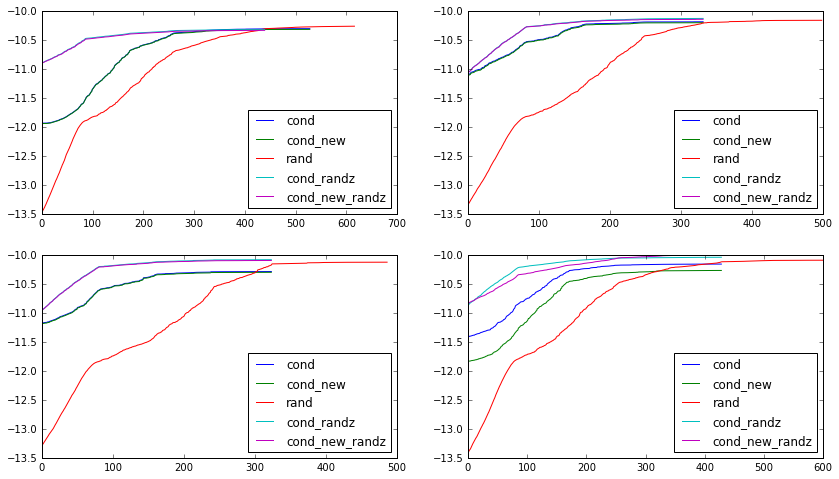

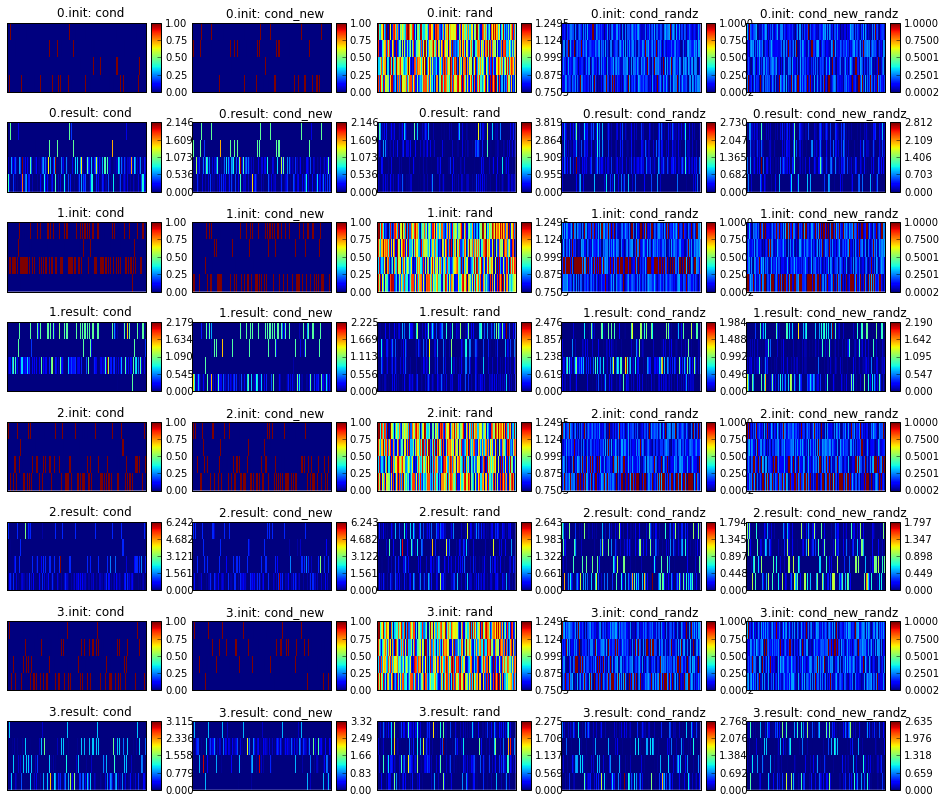

In [21]:
plt.figure(figsize=(14,8))
for indx in xrange(len(ego_paths)):
    plt.subplot(2,2,indx+1)
    for llh, init in zip(itersLLHs[indx], inits):
        plt.plot(-np.log(-np.array(llh)), label=init)
    plt.legend(loc=4)

plt.figure(figsize=(16,14))
for i, initFs in enumerate(initFss):
    for j, initF in enumerate(initFs):
        plt.subplot(2*len(ego_paths), len(inits), j+2*i*len(Fs)+1)
        draw_matrix(initF.T, '{}.init: {}'.format(i, inits[j]))
        plt.subplot(2*len(ego_paths), len(inits), j+(2*i+1)*len(Fs)+1)
        draw_matrix(Fss[i][j].T, '{}.result: {}'.format(i, inits[j]))

На нижних графиках изображены начальные приближения 5 методами (нечетные строки, init в заголовке) и итоговый результат (четные строки, result в заголовке). Видно, что нулевые значения так и остаются нулями и необходимо хотя бы заполнить шумом, что и сделано в новых методах.

На реальных данных лучше всех работают методы *cond_randz* и *cond_new_randz*, но необохдимо дополнительно в этом удостовериться.

Подбираем наилучшее значение параметра *rand_init_coef*, смотрим на поведение процедуры оптимизации:

In [6]:
K = 4
import os
DATA_PATH = '../data/vk/'
ego_paths = [f for f in os.listdir(DATA_PATH) if f.endswith(".ego")]
rand_init_coefs = [0, 0.01, 0.1, 0.2, 0.3, 0.5, 1]
plt.figure(figsize=(18,12))
Fss = []
initFss = []
itersLLHs = []
for indx, ego in enumerate(ego_paths):
    D = cPickle.load(file('../data/vk/{}'.format(ego)))
    G = nx.Graph(D)
    A = np.array(nx.to_numpy_matrix(G))
    Fs = []
    initFs = []
    itersLLH = []
    for ric in log_progress(rand_init_coefs):
        bigClam = BigClam(A, K, initF='cond_randz', debug_output=False, LLH_output=False, eps=1e-2, iter_output=5, rand_init_coef=ric)
        res = bigClam.fit()
        initFs.append(bigClam.initFmode)
        itersLLH.append(bigClam.LLH_output_vals)
        Fs.append(res[0])
    itersLLHs.append(itersLLH)
    initFss.append(initFs)
    Fss.append(Fs)

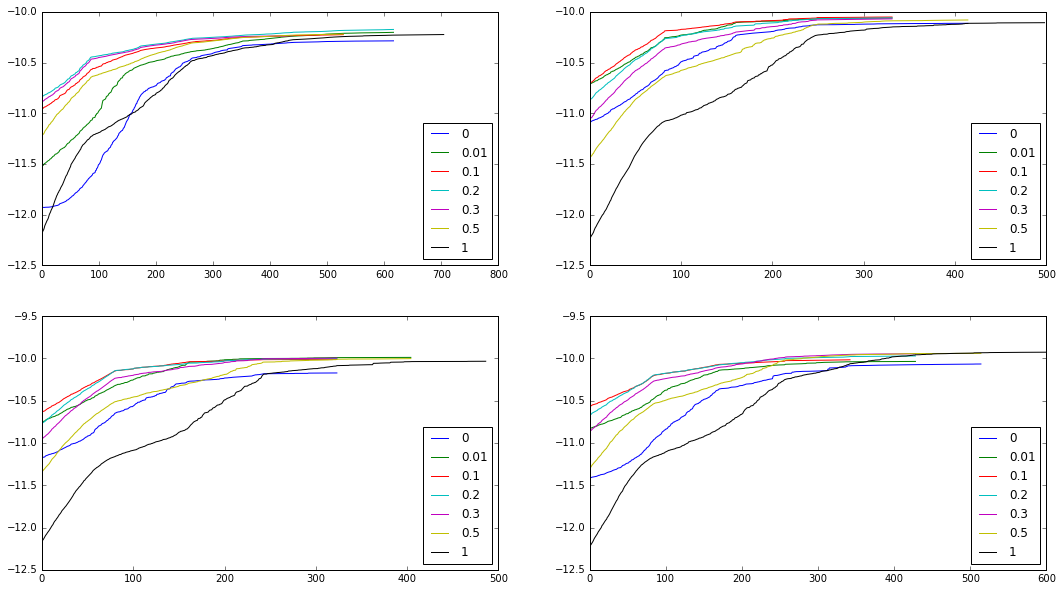

In [11]:
plt.figure(figsize=(18,10))
for indx in xrange(len(ego_paths)):
    plt.subplot(2,2,indx+1)
    for llh, ric in zip(itersLLHs[indx], rand_init_coefs):
        plt.plot(-np.log(-np.array(llh)), label=ric)
    plt.legend(loc=4)
plt.figure(figsize=(6,6))


**Вывод:** Лучше всего себя показывают небольшие значения *rand_init_coef* (на уровне 0.1-0.2). В качестве значения по умолчанию возьмем 0.1 

**Общие выводы:**
* На реальных данных разреженность не дает особого прироста в качестве
* Важно добавить немного шума вместо нулей в матрице F